<p>In this notebook, we'll see how to fine-tune a NLLB-200 machine translation model for a new language.</p>
<p><a href="https://cointegrated.medium.com/how-to-fine-tune-a-nllb-200-model-for-translating-a-new-language-a37fc706b865">https://cointegrated.medium.com/how-to-fine-tune-a-nllb-200-model-for-translating-a-new-language-a37fc706b865</a></p>

# 0. Preliminaries

Installing dependencies:
* `transformers`, as a neural network framework
* `sentencepiece`, a backend for my tokenizer (the algorithm for converting a text into symbols from the model's vocabulary)
* `sacremoses`, a package required for text preprocessing with which NLLB models were pretrained.
* `sacrebleu`, a package for evaluating translation models

In [1]:
CUDA_CORE=2
MODEL_USED="models/nllb_quechua_esp_v4_1_3B"
# MODEL_USED="facebook/nllb-200-1.3B"
# MODEL_USED="facebook/nllb-200-3.3B"
MODEL_SAVE_PATH="models/nllb_inga_esp_complete_1_3B"
LANGUAGE_ORIGIN_LABEL="spa_Latn"
LANGUAGE_TARGET_LABEL="ing_Latn"
LANGUAGE_SIMILAR_LABEL="quechua_Latn" # Quechua Transferr Learning
LANGUAGE_FILE="data/ing_completo.csv"
LANGUAGE_FILE_ORIGIN_LABEL="esp"
LANGUAGE_FILE_TARGET_LABEL="ing"
NORMALIZER_LANGUAGE="es"
!mkdir -p {MODEL_SAVE_PATH}

In [2]:
import locale
def gpe(x=None):
    return "UTF-8"
locale.getpreferredencoding = gpe

In [3]:
!pip install sentencepiece transformers==4.33 datasets sacremoses sacrebleu  -q

In [4]:
!pip install ipywidgets

In [5]:
!pip install scikit-learn
import pandas as pd
from sklearn.model_selection import train_test_split

<h1 id="1.-Exploring-the-data">1. Exploring the data</h1>
<p>&nbsp;</p>

In [6]:
trans_df = pd.read_csv(LANGUAGE_FILE)
print(trans_df.shape)
print(trans_df.columns)

(3260, 2)
Index(['esp', 'ing'], dtype='object')


In [7]:
df_train, df_devtest = train_test_split(trans_df, test_size=0.2, random_state=42)
df_dev, df_test = train_test_split(df_devtest, test_size=0.5, random_state=42)

In [8]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2608 entries, 2951 to 3174
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   esp     2608 non-null   object
 1   ing     2608 non-null   object
dtypes: object(2)
memory usage: 61.1+ KB


In [9]:
df_train.head()

,esp,ing
2951,tunichii,derrumbar (algo)
2555,chukari,asfixiante
2509,aparecer,kawarii
3017,se distribuye,rasiunarii
1459,volverse delgado,ñañuiai


In [10]:
df_dev.info()

<class 'pandas.core.frame.DataFrame'>
Index: 326 entries, 1620 to 2825
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   esp     326 non-null    object
 1   ing     326 non-null    object
dtypes: object(2)
memory usage: 7.6+ KB


In [11]:
df_dev.head()

,esp,ing
1620,hilado,puchkaska
1027,detener,kidachii
2281,trastrabillando,wingu wingu
2870,cualquier,maikanpas
291,delgadito,amchishitu


In [12]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 326 entries, 2643 to 442
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   esp     326 non-null    object
 1   ing     326 non-null    object
dtypes: object(2)
memory usage: 7.6+ KB


In [13]:
df_test.head()

,esp,ing
2643,bramar,ramai
764,doscientos,iskai patsa
1352,salir lana,milmaiai
51,los derechos indígenas sólo se contemplaban en...,"nukanchipa runakuna, chi achka iachag pangakun..."
178,las autoridades garantizarán la adecuada y efe...,"nukanchipa alli iuiaikunata kaugsachispa, wiña..."


# 2. How well does the data fit into a NLLB tokenizer?

In [14]:
from transformers import NllbTokenizer
from tqdm.auto import tqdm, trange

In [15]:
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import NllbTokenizer, AutoModelForSeq2SeqLM, AutoConfig
from tqdm.auto import tqdm, trange

In [16]:
def fix_tokenizer(tokenizer, new_lang=LANGUAGE_TARGET_LABEL):
    """ Add a new language token to the tokenizer vocabulary (this should be done each time after its initialization) """
    old_len = len(tokenizer) - int(new_lang in tokenizer.added_tokens_encoder)
    tokenizer.lang_code_to_id[new_lang] = old_len-1
    tokenizer.id_to_lang_code[old_len-1] = new_lang
    # always move "mask" to the last position
    tokenizer.fairseq_tokens_to_ids["<mask>"] = len(tokenizer.sp_model) + len(tokenizer.lang_code_to_id) + tokenizer.fairseq_offset

    tokenizer.fairseq_tokens_to_ids.update(tokenizer.lang_code_to_id)
    tokenizer.fairseq_ids_to_tokens = {v: k for k, v in tokenizer.fairseq_tokens_to_ids.items()}
    if new_lang not in tokenizer._additional_special_tokens:
        tokenizer._additional_special_tokens.append(new_lang)
    # clear the added token encoder; otherwise a new token may end up there by mistake
    tokenizer.added_tokens_encoder = {}
    tokenizer.added_tokens_decoder = {}

In [17]:
tokenizer = NllbTokenizer.from_pretrained(MODEL_USED)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [18]:
print(tokenizer.convert_ids_to_tokens([262576, 262577, 262578])) # ['zul_Latn', 'quechua_Cyrl', '<mask>']
print(tokenizer.convert_tokens_to_ids(['zul_Latn', 'quechua_Latn', '<mask>'])) # [256202, 256203, 256204]

['zul_Latn', '<mask>', 'quechua_Latn']
[262576, 262578, 262577]


In [19]:
fix_tokenizer(tokenizer, new_lang="quechua_Latn")

In [20]:
print(tokenizer.convert_ids_to_tokens([262576, 262577, 262578])) # ['zul_Latn', 'quechua_Cyrl', '<mask>']
print(tokenizer.convert_tokens_to_ids(['zul_Latn', 'quechua_Latn', '<mask>'])) # [256202, 256203, 256204]

['zul_Latn', 'quechua_Latn', '<mask>']
[262576, 262577, 262578]


In [21]:
import re

def word_tokenize(text):
    # a very naive word tokenizer for languages with English-like orthography
    return re.findall('(\w+|[^\w\s])', text)

In [22]:
smpl = df_train.sample(10000, random_state=42, replace=True)
smpl[LANGUAGE_FILE_ORIGIN_LABEL + '_toks'] = smpl[LANGUAGE_FILE_ORIGIN_LABEL].apply(tokenizer.tokenize)
smpl[LANGUAGE_FILE_TARGET_LABEL + '_toks'] = smpl[LANGUAGE_FILE_TARGET_LABEL].apply(tokenizer.tokenize)

smpl[LANGUAGE_FILE_ORIGIN_LABEL + '_words'] = smpl[LANGUAGE_FILE_ORIGIN_LABEL].apply(word_tokenize)
smpl[LANGUAGE_FILE_TARGET_LABEL + '_words'] = smpl[LANGUAGE_FILE_TARGET_LABEL].apply(word_tokenize)

In [23]:
smpl.sample(5)[[LANGUAGE_FILE_ORIGIN_LABEL, LANGUAGE_FILE_ORIGIN_LABEL + '_words', LANGUAGE_FILE_ORIGIN_LABEL + '_toks', LANGUAGE_FILE_TARGET_LABEL, LANGUAGE_FILE_TARGET_LABEL + '_words', LANGUAGE_FILE_TARGET_LABEL + '_toks']]

,esp,esp_words,esp_toks,ing,ing_words,ing_toks
1618,hilar,[hilar],"[▁hi, lar]",puchkai,[puchkai],"[▁pu, ch, kai]"
3235,fecundado,[fecundado],"[▁fe, c, und, ado]",washbi,[washbi],"[▁wash, bi]"
1692,enojarse,[enojarse],"[▁eno, jar, se]",rabiarii,[rabiarii],"[▁rabi, arii]"
2074,calavera,[calavera],"[▁cala, vera]",uma tullu,"[uma, tullu]","[▁uma, ▁tullu]"
496,así mismo,"[así, mismo]","[▁así, ▁mismo]",chasallata,[chasallata],"[▁chas, allata]"


In [24]:
stats = smpl[[LANGUAGE_FILE_ORIGIN_LABEL + '_toks', LANGUAGE_FILE_TARGET_LABEL + '_toks', LANGUAGE_FILE_ORIGIN_LABEL + '_words', LANGUAGE_FILE_TARGET_LABEL + '_words']].applymap(len).describe()
stats

/tmp/ipykernel_311523/105503015.py:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  stats = smpl[[LANGUAGE_FILE_ORIGIN_LABEL + '_toks', LANGUAGE_FILE_TARGET_LABEL + '_toks', LANGUAGE_FILE_ORIGIN_LABEL + '_words', LANGUAGE_FILE_TARGET_LABEL + '_words']].applymap(len).describe()


,esp_toks,ing_toks,esp_words,ing_words
count,10000.000000,10000.000000,10000.000000,10000.000000
mean,4.203100,4.545000,2.664000,2.088400
std,8.967234,10.580764,6.937472,4.910254
min,1.000000,1.000000,1.000000,1.000000
25%,2.000000,2.000000,1.000000,1.000000
50%,2.000000,2.000000,1.000000,1.000000
75%,3.000000,3.000000,2.000000,1.000000
max,131.000000,163.000000,100.000000,74.000000


In [25]:
print(stats[LANGUAGE_FILE_ORIGIN_LABEL + "_toks"]['mean'] / stats[LANGUAGE_FILE_ORIGIN_LABEL + "_words"]['mean'])
print(stats[LANGUAGE_FILE_TARGET_LABEL + "_toks"]['mean'] / stats[LANGUAGE_FILE_TARGET_LABEL + "_words"]['mean'])

1.57774024024024
2.1763072208389196


In [26]:
print(tokenizer.unk_token, tokenizer.unk_token_id)

<unk> 3


<p>One more check: how often does the token happen in the tokenizer output for quechua? If this is too often, we need to fix it somehow</p>

In [27]:
texts_with_unk = [text for text in tqdm(trans_df[LANGUAGE_FILE_TARGET_LABEL]) if tokenizer.unk_token_id in tokenizer(text).input_ids]
print(len(texts_with_unk))

  0%|          | 0/3260 [00:00<?, ?it/s]

0


In [28]:
# import random
# s = random.sample(texts_with_unk, 5)
# s

In [29]:
# this code is adapted from  the Stopes repo of the NLLB team
# https://github.com/facebookresearch/stopes/blob/main/stopes/pipelines/monolingual/monolingual_line_processor.py#L214

import re
import sys
import typing as tp
import unicodedata
from sacremoses import MosesPunctNormalizer


mpn = MosesPunctNormalizer(lang=NORMALIZER_LANGUAGE)
mpn.substitutions = [
    (re.compile(r), sub) for r, sub in mpn.substitutions
]


def get_non_printing_char_replacer(replace_by: str = " ") -> tp.Callable[[str], str]:
    non_printable_map = {
        ord(c): replace_by
        for c in (chr(i) for i in range(sys.maxunicode + 1))
        # same as \p{C} in perl
        # see https://www.unicode.org/reports/tr44/#General_Category_Values
        if unicodedata.category(c) in {"C", "Cc", "Cf", "Cs", "Co", "Cn"}
    }

    def replace_non_printing_char(line) -> str:
        return line.translate(non_printable_map)

    return replace_non_printing_char

replace_nonprint = get_non_printing_char_replacer(" ")

def preproc(text):
    clean = mpn.normalize(text)
    clean = replace_nonprint(clean)
    # replace 𝓕𝔯𝔞𝔫𝔠𝔢𝔰𝔠𝔞 by Francesca
    clean = unicodedata.normalize("NFKC", clean)
    return clean

In [30]:
texts_with_unk_normed = [text for text in tqdm(texts_with_unk) if tokenizer.unk_token_id in tokenizer(preproc(text)).input_ids]
print(len(texts_with_unk_normed))

0it [00:00, ?it/s]

0


<h1 id="3.-Adding-a-new-language-tag-to-the-tokenizer-and-model">3. Expanding the vocabulary</h1>

In [31]:
from collections import Counter
all_texts = trans_df[LANGUAGE_FILE_TARGET_LABEL]
all_text_normalized = [preproc(t) for t in tqdm(all_texts)]
chars_cnt = Counter(c for t in all_text_normalized for c in t)
required_chars = ''.join([
    k for k, v in chars_cnt.most_common() 
    if v >= 3 and k not in ' '
])

  0%|          | 0/3260 [00:00<?, ?it/s]

In [32]:
all_texts_file = MODEL_SAVE_PATH + "/all_texts_file.csv"
trans_df[LANGUAGE_FILE_TARGET_LABEL].to_csv(all_texts_file, sep='|', index=False, header=False)

In [33]:
import sentencepiece as spm

SPM_PREFIX = MODEL_SAVE_PATH + '/spm_16k'
with open(all_texts_file, 'w') as f:
    for i, text in enumerate(all_texts):
        print(text, file=f)

spm.SentencePieceTrainer.train(
    input=all_texts_file,
    model_prefix=SPM_PREFIX,
    vocab_size=2**11,  # 16K
    character_coverage = 1,
    num_threads=16,
    train_extremely_large_corpus=False,
    add_dummy_prefix=False,
    max_sentencepiece_length=128,
    max_sentence_length=4192*4,
    pad_id=0,
    eos_id=1,
    unk_id=2,
    bos_id=-1,
    required_chars=required_chars,
)

sentencepiece_trainer.cc(78) LOG(INFO) Starts training with : 
trainer_spec {
  input: models/nllb_inga_esp_complete_1_3B/all_texts_file.csv
  input_format: 
  model_prefix: models/nllb_inga_esp_complete_1_3B/spm_16k
  model_type: UNIGRAM
  vocab_size: 2048
  self_test_sample_size: 0
  character_coverage: 1
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 16768
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 128
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  pretokenization_delimiter: 
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: aiuknshcrplmgtwd,bñejoáyfzAxv()19:qT;P80C3í2W6-5
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  seed_sentencepieces_file: 
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id: 2
  bos_id: -1
  eos_id: 1
  pad_id: 0
  unk_piece:

In [34]:
!pip install protobuf==3.19.4

In [35]:
!wget https://raw.githubusercontent.com/protocolbuffers/protobuf/main/python/google/protobuf/internal/builder.py -O /home/americasnlp/uniandes/lib/python3.10/site-packages/google/protobuf/internal/builder.py

--2024-03-15 19:41:57--  https://raw.githubusercontent.com/protocolbuffers/protobuf/main/python/google/protobuf/internal/builder.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4082 (4.0K) [text/plain]
Saving to: ‘/home/americasnlp/uniandes/lib/python3.10/site-packages/google/protobuf/internal/builder.py’

/home/americasnlp/u 100%[===================>]   3.99K  --.-KB/s    in 0s      

2024-03-15 19:41:58 (89.0 MB/s) - ‘/home/americasnlp/uniandes/lib/python3.10/site-packages/google/protobuf/internal/builder.py’ saved [4082/4082]



In [36]:
from sentencepiece import sentencepiece_model_pb2 as sp_pb2_model
# At this step, the code may throw an error about protobuf. Do as it tells.
from transformers import NllbTokenizer

# reading the NLLB and the Tyvan sentencepiece models into a native format
tokenizer = NllbTokenizer.from_pretrained(MODEL_USED)
fix_tokenizer(tokenizer, new_lang="quechua_Latn")
sp_trained = spm.SentencePieceProcessor(model_file=f'{SPM_PREFIX}.model')
added_spm = sp_pb2_model.ModelProto()
added_spm.ParseFromString(sp_trained.serialized_model_proto())
old_spm = sp_pb2_model.ModelProto()
old_spm.ParseFromString(tokenizer.sp_model.serialized_model_proto())

# adding the missing tokens to the NLLB sentencepiece model
nllb_tokens_set = {p.piece for p in old_spm.pieces}
prev_min_score = old_spm.pieces[-1].score
for p in added_spm.pieces:
    piece = p.piece
    if piece not in nllb_tokens_set:
        new_p = sp_pb2_model.ModelProto().SentencePiece()
        new_p.piece = piece
        # for all new tokens, I'll set a lower score (priority)
        new_p.score = p.score + prev_min_score
        old_spm.pieces.append(new_p)

# saving the result to disk
NEW_SPM_NAME = MODEL_SAVE_PATH + '/spm_nllb_268k.model'
with open(NEW_SPM_NAME, 'wb') as f:
    f.write(old_spm.SerializeToString())

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [37]:
from transformers import AutoModelForSeq2SeqLM
model_name = MODEL_USED

# loading the tokenizers
tokenizer_old = NllbTokenizer.from_pretrained(model_name)
fix_tokenizer(tokenizer_old, new_lang="quechua_Latn")
tokenizer = NllbTokenizer.from_pretrained(model_name, vocab_file=NEW_SPM_NAME)
print(len(tokenizer_old), len(tokenizer)) # 256204, 268559
added_vocab = set(tokenizer.get_vocab()).difference(set(tokenizer_old.get_vocab()))
print(len(added_vocab))  # 12355

# loading and resizing the model
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)
model.resize_token_embeddings(len(tokenizer))

# re-initializing the new embeddings
for t in tqdm(added_vocab):
    tt = tokenizer_old(t, add_special_tokens=False).input_ids
    if len(tt) == 0:
        tt = [tokenizer_old.unk_token_id]
    idx = tokenizer.convert_tokens_to_ids(t)
    model.model.shared.weight.data[idx] = model.model.shared.weight.data[tt].mean(0)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


262579 263837
1258


2024-03-15 19:42:00.792419: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-15 19:42:00.940836: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-15 19:42:01.558322: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-03-15 19:42:01.558384: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] 

  0%|          | 0/1258 [00:00<?, ?it/s]

<h1 id="4.-Adding-a-new-language-tag-to-the-tokenizer-and-model">4. Adding a new language tag to the tokenizer and model</h1>

In [38]:
from transformers import AutoModelForSeq2SeqLM
from transformers import NllbTokenizer

In [39]:
print(tokenizer_old.convert_ids_to_tokens([262576, 262577, 262578])) # ['zul_Latn', 'quechua_Cyrl', '<mask>']
print(tokenizer_old.convert_tokens_to_ids(['zul_Latn', 'quechua_Latn', '<mask>'])) # [256202, 256203, 256204]

fix_tokenizer(tokenizer, new_lang="quechua_Latn")
print(tokenizer.convert_ids_to_tokens([263137, 263138, 263139])) # ['zul_Latn', 'quechua_Cyrl', '<mask>']
print(tokenizer.convert_tokens_to_ids(['zul_Latn', 'quechua_Cyrl', '<mask>'])) # [256202, 256203, 256204]

['zul_Latn', 'quechua_Latn', '<mask>']
[262576, 262577, 262578]
['urku', 'lisinsia', '▁willarai']
[263834, 3, 263836]


In [40]:
print(len(tokenizer))
print(len(added_vocab))
print(tokenizer.convert_ids_to_tokens([263138, 263139]))

263837
1258
['lisinsia', '▁willarai']


In [41]:
# tokenizer = NllbTokenizer.from_pretrained(MODEL_USED)
# print(len(tokenizer))
# print(tokenizer.convert_ids_to_tokens([256202, 256203]))

In [42]:
def fix_tokenizer(tokenizer, new_lang=LANGUAGE_TARGET_LABEL):
    """
    Add a new language token to the tokenizer vocabulary
    (this should be done each time after its initialization)
    """
    old_len = len(tokenizer) - int(new_lang in tokenizer.added_tokens_encoder)
    tokenizer.lang_code_to_id[new_lang] = old_len-1
    tokenizer.id_to_lang_code[old_len-1] = new_lang
    # always move "mask" to the last position
    tokenizer.fairseq_tokens_to_ids["<mask>"] = len(tokenizer.sp_model) + len(tokenizer.lang_code_to_id) + tokenizer.fairseq_offset

    tokenizer.fairseq_tokens_to_ids.update(tokenizer.lang_code_to_id)
    tokenizer.fairseq_ids_to_tokens = {v: k for k, v in tokenizer.fairseq_tokens_to_ids.items()}
    if new_lang not in tokenizer._additional_special_tokens:
        tokenizer._additional_special_tokens.append(new_lang)
    # clear the added token encoder; otherwise a new token may end up there by mistake
    tokenizer.added_tokens_encoder = {}
    tokenizer.added_tokens_decoder = {}

In [43]:
fix_tokenizer(tokenizer)

In [44]:
print(tokenizer.convert_ids_to_tokens([262576 + len(added_vocab) + 1, 262576 + len(added_vocab) + 2, 262576 + len(added_vocab) + 3])) # ['zul_Latn', LANGUAGE_TARGET_LABEL, '<mask>']
print(tokenizer.convert_tokens_to_ids(['quechua_Latn', LANGUAGE_TARGET_LABEL, '<mask>'])) # [256202, 256203, 256204]
# this is consistent now, wow!

['quechua_Latn', 'ing_Latn', '<mask>']
[263835, 263836, 263837]


In [45]:
added_token_id = tokenizer.convert_tokens_to_ids(LANGUAGE_TARGET_LABEL)
similar_lang_id = tokenizer.convert_tokens_to_ids(LANGUAGE_SIMILAR_LABEL)
print(added_token_id, similar_lang_id)

263836 263835


In [46]:
model = AutoModelForSeq2SeqLM.from_pretrained(MODEL_USED)
model.resize_token_embeddings(len(tokenizer))

You are resizing the embedding layer without providing a `pad_to_multiple_of` parameter. This means that the new embedding dimension will be 263838. This might induce some performance reduction as *Tensor Cores* will not be available. For more details about this, or help on choosing the correct value for resizing, refer to this guide: https://docs.nvidia.com/deeplearning/performance/dl-performance-matrix-multiplication/index.html#requirements-tc


Embedding(263838, 1024)

In [47]:
# moving the embedding for "mask" to its new position
model.model.shared.weight.data[added_token_id+1] = model.model.shared.weight.data[added_token_id]
# initializing new language token with a token of a similar language
model.model.shared.weight.data[added_token_id] = model.model.shared.weight.data[similar_lang_id]

<h1 id="5.-Preparing-the-training-loop">5. Preparing the training loop</h1>

In [48]:
import gc
import random
import numpy as np
import torch
from tqdm.auto import tqdm, trange
from transformers.optimization import Adafactor
from transformers import get_constant_schedule_with_warmup

def cleanup():
    """Try to free GPU memory"""
    gc.collect()
    torch.cuda.empty_cache()

cleanup()

In [49]:
model.cuda(CUDA_CORE);

In [50]:
optimizer = Adafactor(
    [p for p in model.parameters() if p.requires_grad],
    scale_parameter=False,
    relative_step=False,
    lr=1e-4,
    clip_threshold=1.0,
    weight_decay=1e-3,
)

In [51]:
batch_size = 16  # 32 already doesn't fit well to 15GB of GPU memory
max_length = 128
warmup_steps = 1000
training_steps = 57000

In [52]:
losses = []
scheduler = get_constant_schedule_with_warmup(optimizer, num_warmup_steps=warmup_steps)

In [53]:
LANGS = [(LANGUAGE_FILE_ORIGIN_LABEL, LANGUAGE_ORIGIN_LABEL), (LANGUAGE_FILE_TARGET_LABEL, LANGUAGE_TARGET_LABEL)]

def get_batch_pairs(batch_size, data=df_train):
    (l1, long1), (l2, long2) = random.sample(LANGS, 2)
    xx, yy = [], []
    for _ in range(batch_size):
        item = data.iloc[random.randint(0, len(data)-1)]
        xx.append(preproc(item[l1]))
        yy.append(preproc(item[l2]))
    return xx, yy, long1, long2

print(get_batch_pairs(1))

(['comino'], ['mangas'], 'spa_Latn', 'ing_Latn')


<h1 id="6.-The-training-loop">6. The training loop</h1>

In [54]:
model.train()
x, y, loss = None, None, None
cleanup()

tq = trange(len(losses), training_steps)
for i in tq:
    xx, yy, lang1, lang2 = get_batch_pairs(batch_size)
    try:
        tokenizer.src_lang = lang1
        x = tokenizer(xx, return_tensors='pt', padding=True, truncation=True, max_length=max_length).to(model.device)
        tokenizer.src_lang = lang2
        y = tokenizer(yy, return_tensors='pt', padding=True, truncation=True, max_length=max_length).to(model.device)
        y.input_ids[y.input_ids == tokenizer.pad_token_id] = -100

        loss = model(**x, labels=y.input_ids).loss
        loss.backward()
        losses.append(loss.item())

        optimizer.step()
        optimizer.zero_grad(set_to_none=True)
        scheduler.step()

    except RuntimeError as e:
        optimizer.zero_grad(set_to_none=True)
        x, y, loss = None, None, None
        cleanup()
        print('error', max(len(s) for s in xx + yy), e)
        continue

    if i % 1000 == 0:
        print(i, np.mean(losses[-1000:]))

    if i % 1000 == 0 and i > 0:
        model.save_pretrained(MODEL_SAVE_PATH)
        tokenizer.save_pretrained(MODEL_SAVE_PATH)

  0%|          | 0/57000 [00:00<?, ?it/s]

0 10.713159561157227
1000 3.769779067158699
2000 1.073115170970559
3000 0.4700971578359604
4000 0.2885669228117913
5000 0.19261414556391537
6000 0.15339048879407347
7000 0.12941031897370703
8000 0.1097326659350656
9000 0.09698472594254418
10000 0.08797094197419937
11000 0.07835928777232766
12000 0.07467687892576214
13000 0.07013789918355177
14000 0.06448220567640965
15000 0.06522413249590318
16000 0.06057262893370353
17000 0.06020271181875432
18000 0.054936315704318985
19000 0.05578777091324446
20000 0.05474648337402323
21000 0.05815764590387698
22000 0.05191012753040559
23000 0.052699552238744216
24000 0.05042192924009578
25000 0.05074736872821813
26000 0.051356128581748636
27000 0.04897872602735879
28000 0.04799908670772857
29000 0.04842661103440332
30000 0.04587277699486367
31000 0.049594685582760575
32000 0.04733068898955389
33000 0.047715942051352614
34000 0.04428324426538893
35000 0.04458685315647381
36000 0.044199051522446096
37000 0.04462112810656254
38000 0.046169086028989115


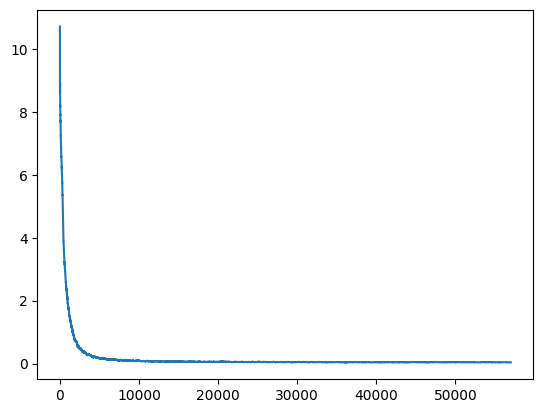

In [55]:
pd.Series(losses).ewm(100).mean().plot();

In [56]:
def translate(text, src_lang=LANGUAGE_ORIGIN_LABEL, tgt_lang=LANGUAGE_TARGET_LABEL, a=16, b=1.5, max_input_length=1024, **kwargs):
    tokenizer.src_lang = src_lang
    tokenizer.tgt_lang = tgt_lang
    inputs = tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=max_input_length)
    result = model.generate(
        **inputs.to(model.device),
        forced_bos_token_id=tokenizer.convert_tokens_to_ids(tgt_lang),
        max_new_tokens=int(a + b * inputs.input_ids.shape[1]),
        **kwargs
    )
    #print(inputs.input_ids.shape[1], result.shape[1])
    return tokenizer.batch_decode(result, skip_special_tokens=True)

In [57]:
xx, yy, lang1, lang2 = get_batch_pairs(1, data=df_dev)
print(xx)
print(yy)
model.eval()
print(translate(xx[0], lang1, lang2, no_repeat_ngram_size=3, num_beams=5))

['changalai']
['cabalgar']
['cabalgar']


In [58]:
!ls -alsh $MODEL_SAVE_PATH

total 5.2G
4.0K drwxrwxr-x  2 americasnlp americasnlp 4.0K Mar 15 19:51 .
4.0K drwxr-xr-x 14 americasnlp americasnlp 4.0K Mar 15 19:40 ..
 56K -rw-rw-r--  1 americasnlp americasnlp  53K Mar 15 19:41 all_texts_file.csv
4.0K -rw-rw-r--  1 americasnlp americasnlp  857 Mar 16 04:19 config.json
4.0K -rw-rw-r--  1 americasnlp americasnlp  184 Mar 16 04:19 generation_config.json
5.2G -rw-rw-r--  1 americasnlp americasnlp 5.2G Mar 16 04:19 pytorch_model.bin
4.8M -rw-rw-r--  1 americasnlp americasnlp 4.8M Mar 16 04:19 sentencepiece.bpe.model
4.0K -rw-rw-r--  1 americasnlp americasnlp 3.5K Mar 16 04:19 special_tokens_map.json
264K -rw-rw-r--  1 americasnlp americasnlp 263K Mar 15 19:41 spm_16k.model
 32K -rw-rw-r--  1 americasnlp americasnlp  32K Mar 15 19:41 spm_16k.vocab
4.8M -rw-rw-r--  1 americasnlp americasnlp 4.8M Mar 15 19:41 spm_nllb_268k.model
4.0K -rw-rw-r--  1 americasnlp americasnlp  570 Mar 16 04:19 tokenizer_config.json


<h1 id="7.-Using-the-model">7. Testing the model</h1>

In [59]:
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import NllbTokenizer, AutoModelForSeq2SeqLM, AutoConfig
from tqdm.auto import tqdm, trange

In [60]:
def fix_tokenizer(tokenizer, new_lang=LANGUAGE_TARGET_LABEL):
    """ Add a new language token to the tokenizer vocabulary (this should be done each time after its initialization) """
    old_len = len(tokenizer) - int(new_lang in tokenizer.added_tokens_encoder)
    tokenizer.lang_code_to_id[new_lang] = old_len-1
    tokenizer.id_to_lang_code[old_len-1] = new_lang
    # always move "mask" to the last position
    tokenizer.fairseq_tokens_to_ids["<mask>"] = len(tokenizer.sp_model) + len(tokenizer.lang_code_to_id) + tokenizer.fairseq_offset

    tokenizer.fairseq_tokens_to_ids.update(tokenizer.lang_code_to_id)
    tokenizer.fairseq_ids_to_tokens = {v: k for k, v in tokenizer.fairseq_tokens_to_ids.items()}
    if new_lang not in tokenizer._additional_special_tokens:
        tokenizer._additional_special_tokens.append(new_lang)
    # clear the added token encoder; otherwise a new token may end up there by mistake
    tokenizer.added_tokens_encoder = {}
    tokenizer.added_tokens_decoder = {}

In [61]:
model = AutoModelForSeq2SeqLM.from_pretrained(MODEL_SAVE_PATH).cuda(CUDA_CORE)
tokenizer = NllbTokenizer.from_pretrained(MODEL_SAVE_PATH)
fix_tokenizer(tokenizer, new_lang="quechua_Latn")
fix_tokenizer(tokenizer)
# print(tokenizer.convert_ids_to_tokens([262576 + len(added_vocab) + 1, 262576 + len(added_vocab) + 2, 262576 + len(added_vocab) + 3])) # ['zul_Latn', LANGUAGE_TARGET_LABEL, '<mask>']
print(tokenizer.convert_tokens_to_ids([LANGUAGE_TARGET_LABEL, '<mask>'])) # [256202, 256203, 256204]
# this is consistent now, wow!

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


[263836, 263837]


In [62]:
def translate(text, src_lang=LANGUAGE_ORIGIN_LABEL, tgt_lang=LANGUAGE_TARGET_LABEL, a=32, b=3, max_input_length=1024, num_beams=4, **kwargs):
    tokenizer.src_lang = src_lang
    tokenizer.tgt_lang = tgt_lang
    inputs = tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=max_input_length)
    result = model.generate(
        **inputs.to(model.device),
        forced_bos_token_id=tokenizer.convert_tokens_to_ids(tgt_lang),
        max_new_tokens=int(a + b * inputs.input_ids.shape[1]),
        num_beams=num_beams,
        **kwargs
    )
    return tokenizer.batch_decode(result, skip_special_tokens=True)

In [63]:
t = "las canciones de amor me gustan mucho"
print(translate(t, LANGUAGE_ORIGIN_LABEL, LANGUAGE_TARGET_LABEL))

['birsiai']


In [64]:
translate(t, LANGUAGE_ORIGIN_LABEL, LANGUAGE_TARGET_LABEL, do_sample=True, num_beams=1, temperature=1.5)

['birsiai']

In [65]:
t = "kuyakuyllawan takitam anchata kuyani"
print(translate(t, LANGUAGE_TARGET_LABEL, LANGUAGE_ORIGIN_LABEL))

['¡Tenga!']


In [66]:
translate(t, LANGUAGE_TARGET_LABEL, LANGUAGE_ORIGIN_LABEL, do_sample=True, num_beams=1, temperature=1.5)

['¡Tenga!']

In [67]:
def batched_translate(texts, batch_size=8, **kwargs):
    """Translate texts in batches of similar length"""
    idxs, texts2 = zip(*sorted(enumerate(texts), key=lambda p: len(p[1]), reverse=True))
    results = []
    for i in trange(0, len(texts2), batch_size):
        results.extend(translate(texts2[i: i+batch_size], **kwargs))
    return [p for i, p in sorted(zip(idxs, results))]

In [68]:
# df_test[LANGUAGE_FILE_ORIGIN_LABEL + '_translated'] = batched_translate(df_test["LANGUAGE_FILE_TARGET_LABEL"], src_lang=LANGUAGE_TARGET_LABEL, tgt_lang=LANGUAGE_ORIGIN_LABEL)
# df_test[LANGUAGE_FILE_TARGET_LABEL + '_translated'] = batched_translate(df_test["LANGUAGE_FILE_ORIGIN_LABEL"], src_lang=LANGUAGE_ORIGIN_LABEL, tgt_lang=LANGUAGE_TARGET_LABEL)

In [69]:
df_test[LANGUAGE_FILE_ORIGIN_LABEL + '_translated'] = [translate(t, LANGUAGE_TARGET_LABEL, LANGUAGE_ORIGIN_LABEL)[0] for t in tqdm(df_test[LANGUAGE_FILE_TARGET_LABEL])]
df_test[LANGUAGE_FILE_TARGET_LABEL + '_translated'] = [translate(t, LANGUAGE_ORIGIN_LABEL, LANGUAGE_TARGET_LABEL)[0] for t in tqdm(df_test[LANGUAGE_FILE_ORIGIN_LABEL])]

  0%|          | 0/326 [00:00<?, ?it/s]

  0%|          | 0/326 [00:00<?, ?it/s]

In [70]:
import sacrebleu
bleu_calc = sacrebleu.BLEU()
chrf_calc = sacrebleu.CHRF(word_order=2)  # this metric is called ChrF++

In [71]:
print(bleu_calc.corpus_score(df_test[LANGUAGE_FILE_ORIGIN_LABEL + '_translated'].tolist(), [df_test[LANGUAGE_FILE_ORIGIN_LABEL].tolist()]))
print(chrf_calc.corpus_score(df_test[LANGUAGE_FILE_ORIGIN_LABEL + '_translated'].tolist(), [df_test[LANGUAGE_FILE_ORIGIN_LABEL].tolist()]))
print(bleu_calc.corpus_score(df_test[LANGUAGE_FILE_TARGET_LABEL + '_translated'].tolist(), [df_test[LANGUAGE_FILE_TARGET_LABEL].tolist()]))
print(chrf_calc.corpus_score(df_test[LANGUAGE_FILE_TARGET_LABEL + '_translated'].tolist(), [df_test[LANGUAGE_FILE_TARGET_LABEL].tolist()]))

BLEU = 0.78 15.1/1.4/0.2/0.1 (BP = 1.000 ratio = 1.507 hyp_len = 1505 ref_len = 999)
chrF2++ = 21.15
BLEU = 1.08 16.4/2.3/0.4/0.1 (BP = 1.000 ratio = 1.125 hyp_len = 933 ref_len = 829)
chrF2++ = 27.38


In [72]:
pd.options.display.max_colwidth = 100

In [73]:
df_test.sample(10, random_state=42)[[LANGUAGE_FILE_TARGET_LABEL, LANGUAGE_FILE_ORIGIN_LABEL, LANGUAGE_FILE_TARGET_LABEL + '_translated', LANGUAGE_FILE_ORIGIN_LABEL + '_translated']]

,ing,esp,ing_translated,esp_translated
3019,bandarii,se divide,chaugpirii,partirse
2272,wigsa,estómago,wigsa,estómago
1837,sisu,parásito blanco,iura,¡Ojalá que!
313,animarii,animarse,alli iuiachirii,convenir
1220,llulluiai,volverse tierno,llulluiai,volverse anémico
905,kallamba,hongo,jundu,palabras
2258,wawa chaparu,apenas enmontado,Amara,potrero
2063,ukucha,ratón,kancha pisku,ratoncito
2223,warmi chundur,chundur,jinti chundur,chundur
203,chi nukanchikikin agllaskakunaka iukankunami allilla rigsinga u chikuna rurai puriskakuna kanga,"en las entidades territoriales habrá también consejos de planeación, según lo determine la ley",tiq sqaidoine imamlansleidoilsi,"el hecho de haberme enfrentado a esta dura tarea, sin una experiencia previa en traducción, me d..."
